## Drzewo decyzyjne

Stałe

In [65]:
SEED = 249919
SAMPLES = 2419

Generowanie danych

In [66]:
import numpy as np
from sklearn.datasets import make_blobs, make_classification
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

def NormalizeData(data):
    return (data - np.min(data)) / (np.max(data) - np.min(data))

X, y = make_blobs(n_samples=SAMPLES, random_state=SEED, centers=8)
y = y < 4
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=SEED)

X_class, y_class = make_classification(n_samples=SAMPLES, n_classes=2, n_redundant = 0, n_informative = 2, n_features=2, random_state=SEED)
X_class_train, X_class_test, y_class_train, y_class_test = train_test_split(X_class, y_class, test_size=0.2, random_state=SEED)


Text(0.5, 1.0, 'Classification')

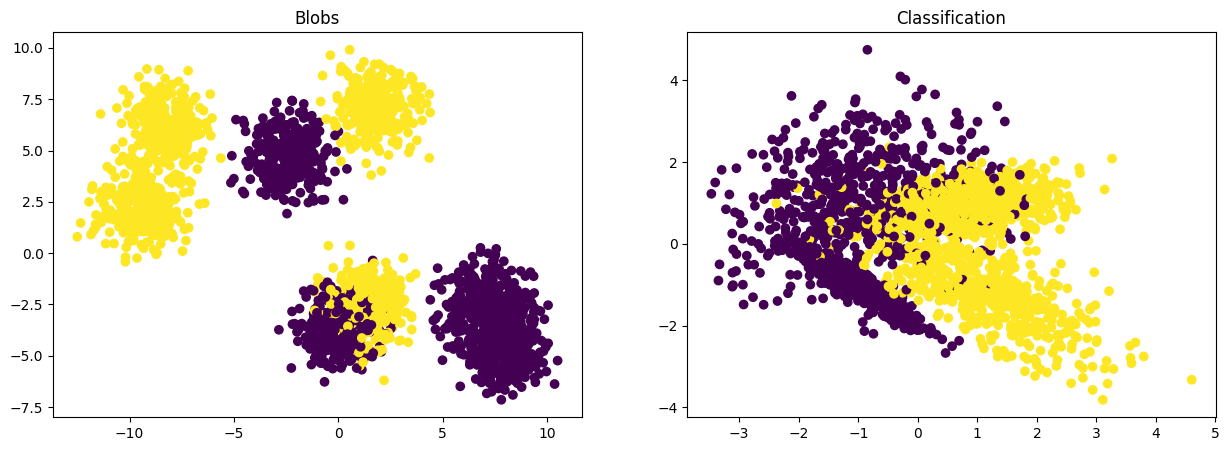

In [67]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

ax1.scatter(X[:,0], X[:,1], label = "Data", c = y)
ax1.set_title('Blobs')

ax2.scatter(X_class[:,0], X_class[:,1], label = "Data", c = y_class)
ax2.set_title("Classification")

Implementacja scipy blobs

In [68]:
from sklearn.tree import DecisionTreeClassifier

clf = DecisionTreeClassifier(criterion = 'entropy', random_state=0, max_depth=10)
clf.fit(X_train,y_train)
pred = clf.predict(X_test)
scikit_score_blobs = clf.score(X_test, y_test)

print(f"Tree depth {clf.get_depth()}")

Tree depth 10


Text(0.5, 1.0, 'Score: 0.9421')

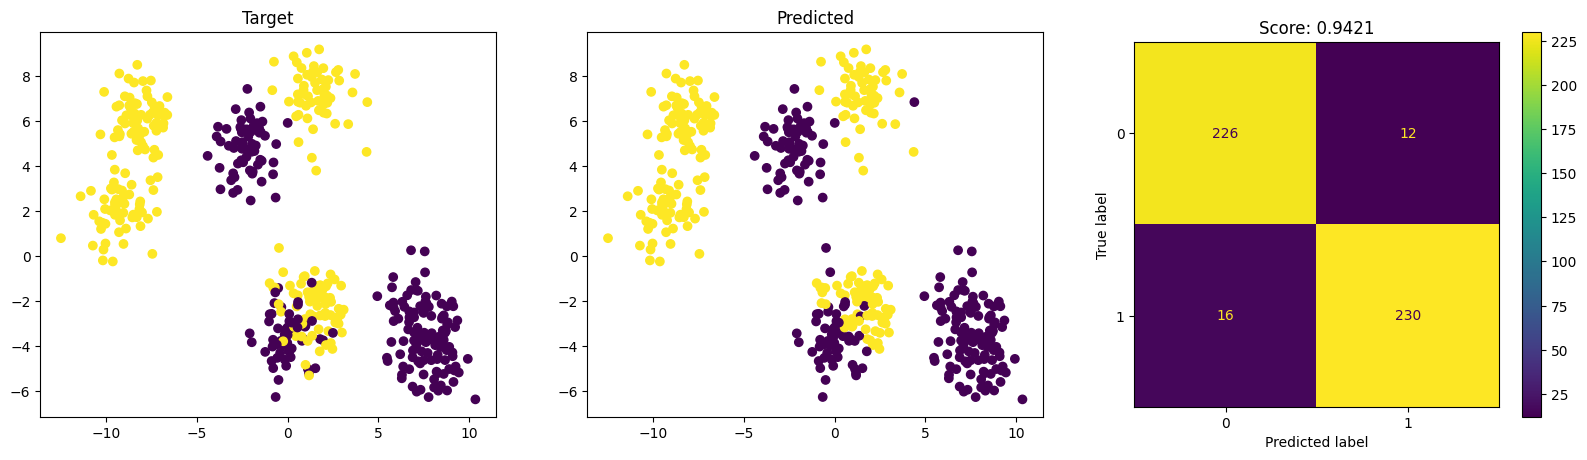

In [69]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(20, 5))

ax1.scatter(X_test[:,0], X_test[:,1], label = "Data", c = y_test)
ax1.set_title('Target')

ax2.scatter(X_test[:,0], X_test[:,1], label = "Data", c = pred)
ax2.set_title("Predicted")

cm = confusion_matrix(y_test, pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(ax = ax3)
disp.ax_.set_title(f"Score: {scikit_score_blobs:.4f}")

Implementacja scipy classification

In [70]:
clf = DecisionTreeClassifier(criterion = 'entropy', random_state=0, max_depth=10)
clf.fit(X_class_train,y_class_train)
pred = clf.predict(X_class_test)
scikit_score_classification = clf.score(X_class_test, y_class_test)

print(f"Tree depth {clf.get_depth()}")

Tree depth 10


Text(0.5, 1.0, 'Score: 0.9132')

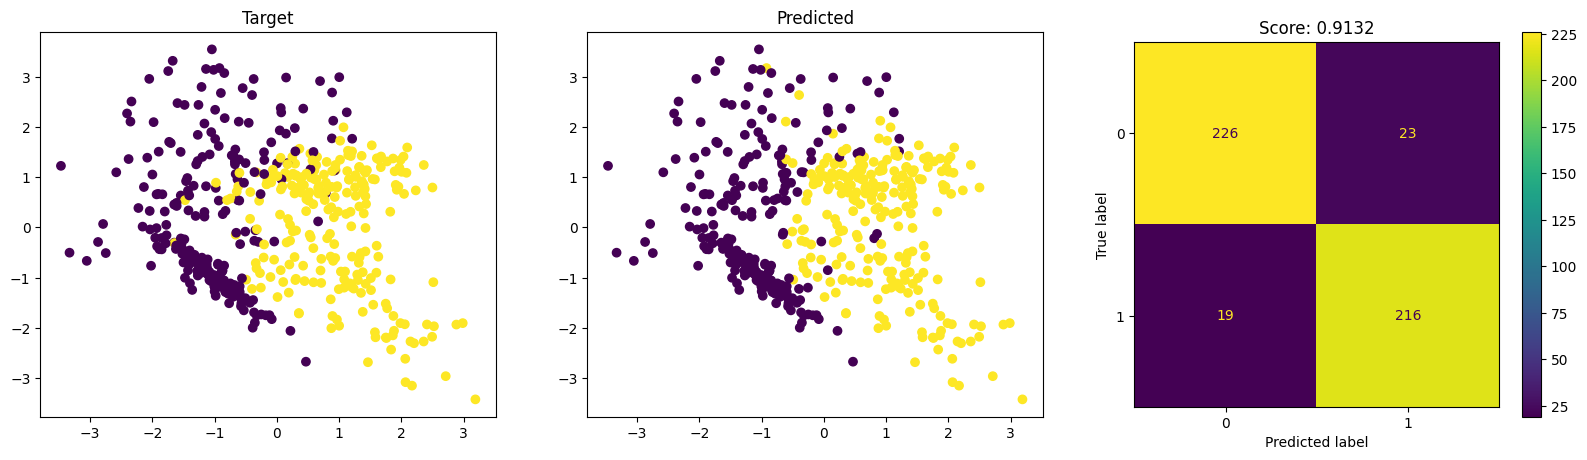

In [71]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(20, 5))

ax1.scatter(X_class_test[:,0], X_class_test[:,1], label = "Data", c = y_class_test)
ax1.set_title('Target')

ax2.scatter(X_class_test[:,0], X_class_test[:,1], label = "Data", c = pred)
ax2.set_title("Predicted")

cm = confusion_matrix(y_class_test, pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(ax = ax3)
disp.ax_.set_title(f"Score: {scikit_score_classification:.4f}")

Implementacja numeryczna

In [72]:
import numpy as np
import random

class Node():
    def __init__(self, feature_index=None, split_point=None, left=None, right=None, info_gain=None, value=None):
        
        self.feature_index = feature_index
        self.split_point = split_point
        self.left = left
        self.right = right
        self.info_gain = info_gain
        
        self.value = value

class DecisionTree():
    def __init__(self, min_samples_split=2, max_depth=2, percentage = 0.2):
        self.root = None
        
        self.min_samples_split = min_samples_split
        self.max_depth = max_depth
        self.percentage = percentage
        
    def build_tree(self, dataset, curr_depth=0):
        X, Y = dataset[:,:-1], dataset[:,-1]
        num_samples, num_features = np.shape(X)
        
        if num_samples>=self.min_samples_split and curr_depth<=self.max_depth:
            
            best_split = self.get_best_split(dataset, num_features, self.percentage)
            
            if best_split["info_gain"]>0:
                left_subtree = self.build_tree(best_split["dataset_left"], curr_depth+1)
                right_subtree = self.build_tree(best_split["dataset_right"], curr_depth+1)
                
                return Node(best_split["feature_index"], best_split["split_point"], 
                            left_subtree, right_subtree, best_split["info_gain"])
        
        leaf_value = self.calculate_leaf_value(Y)
        return Node(value=leaf_value)
    
    def get_best_split(self, dataset, num_features, percentage):
        best_split = {}
        max_info_gain = -float("inf")

        how_much = int(dataset.shape[0] * percentage)
        indexes = random.sample(range(0, dataset.shape[0]), how_much)
        new_dataset = dataset[indexes,:]

        if new_dataset.shape[0] <= 5:
            new_dataset = dataset
        
        for feature_index in range(num_features):
            feature_values = new_dataset[:, feature_index]
            possible_split_points = np.unique(feature_values)
            for split_point in possible_split_points:

                dataset_left, dataset_right = self.split(new_dataset, feature_index, split_point)
                if len(dataset_left)>0 and len(dataset_right)>0:
                    y, left_y, right_y = new_dataset[:, -1], dataset_left[:, -1], dataset_right[:, -1]
                    curr_info_gain = self.information_gain(y, left_y, right_y)
                    
                    if curr_info_gain>max_info_gain:
                        best_split["feature_index"] = feature_index
                        best_split["split_point"] = split_point
                        best_split["dataset_left"] = dataset_left
                        best_split["dataset_right"] = dataset_right
                        best_split["info_gain"] = curr_info_gain
                        max_info_gain = curr_info_gain
                        
        return best_split
    
    def split(self, dataset, feature_index, split_point):
        #dataset[row[feature_index]<=split_point]]
        dataset_left = np.array([row for row in dataset if row[feature_index]<=split_point])
        dataset_right = np.array([row for row in dataset if row[feature_index]>split_point])
        return dataset_left, dataset_right
    
    def information_gain(self, parent, left_child, right_child):
        weight_left = len(left_child) / len(parent)
        weight_right = len(right_child) / len(parent)
        return self.entropy(parent) - (weight_left*self.entropy(left_child) + weight_right*self.entropy(right_child))
    
    def entropy(self, y):
        class_labels = np.unique(y)
        entropy = 0
        for cls in class_labels:
            probability = len(y[y == cls]) / len(y)
            entropy += -probability * np.log2(probability)
        return entropy
        
    def calculate_leaf_value(self, Y):
        Y = list(Y)
        return max(Y, key=Y.count)
        
    def fit(self, X, Y):
        dataset = np.concatenate((X, Y.reshape(-1,1)), axis=1)
        self.root = self.build_tree(dataset)

    def score(self, x_test, y_test):
        pred = self.predict(x_test)
        counter = 0
        for i in range(y_test.shape[0]):
            if y_test[i] == pred[i]:
                counter += 1
        return counter / y_test.shape[0]
    
    def predict(self, X):
        preditions = [self.make_prediction(x, self.root) for x in X]
        return preditions
    
    def make_prediction(self, x, tree):
        if tree.value!=None: return tree.value
        feature_val = x[tree.feature_index]
        if feature_val<=tree.split_point:
            return self.make_prediction(x, tree.left)
        else:
            return self.make_prediction(x, tree.right)

Predykcja Blobs

In [73]:
classifier = DecisionTree(min_samples_split=3, max_depth=10, percentage=0.5)
classifier.fit(X_train, y_train)
pred = classifier.predict(X_test)
own_score_blobs = classifier.score(X_test, y_test)

Text(0.5, 1.0, 'Score: 0.9174')

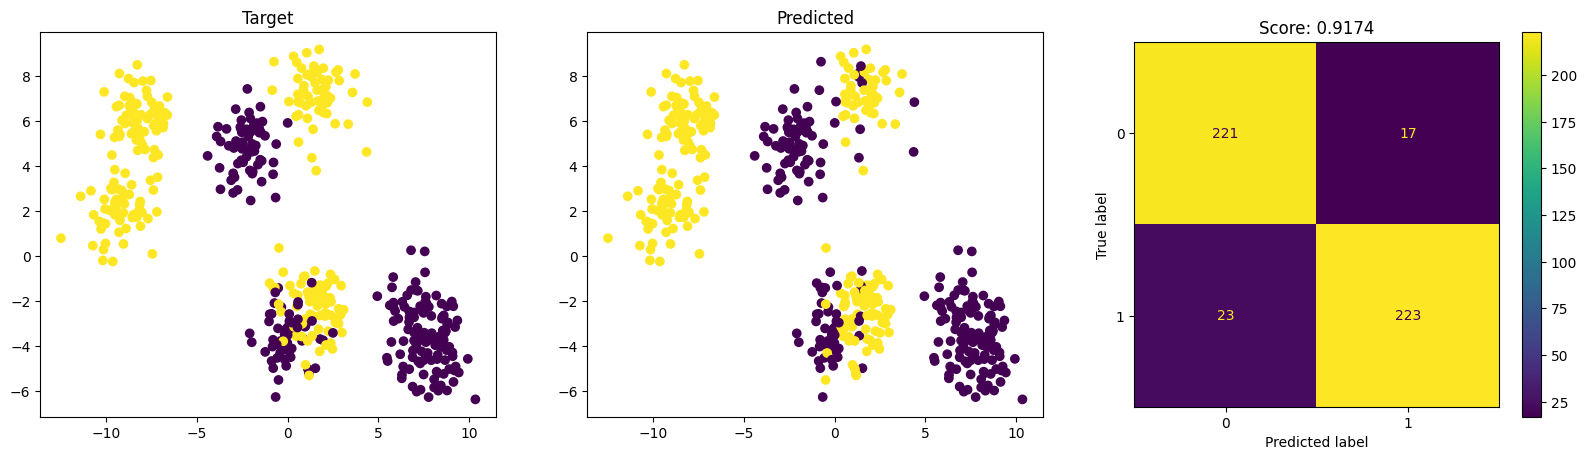

In [74]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(20, 5))

ax1.scatter(X_test[:,0], X_test[:,1], label = "Data", c = y_test)
ax1.set_title('Target')

ax2.scatter(X_test[:,0], X_test[:,1], label = "Data", c = pred)
ax2.set_title("Predicted")

cm = confusion_matrix(y_test, pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(ax = ax3)
disp.ax_.set_title(f"Score: {own_score_blobs:.4f}")


Predykcja Class

In [75]:
classifier = DecisionTree(min_samples_split=2, max_depth=10, percentage=0.5)
classifier.fit(X_class_train, y_class_train)
pred = classifier.predict(X_class_test)
own_score_classification = classifier.score(X_class_test, y_class_test)

Text(0.5, 1.0, 'Score: 0.9070')

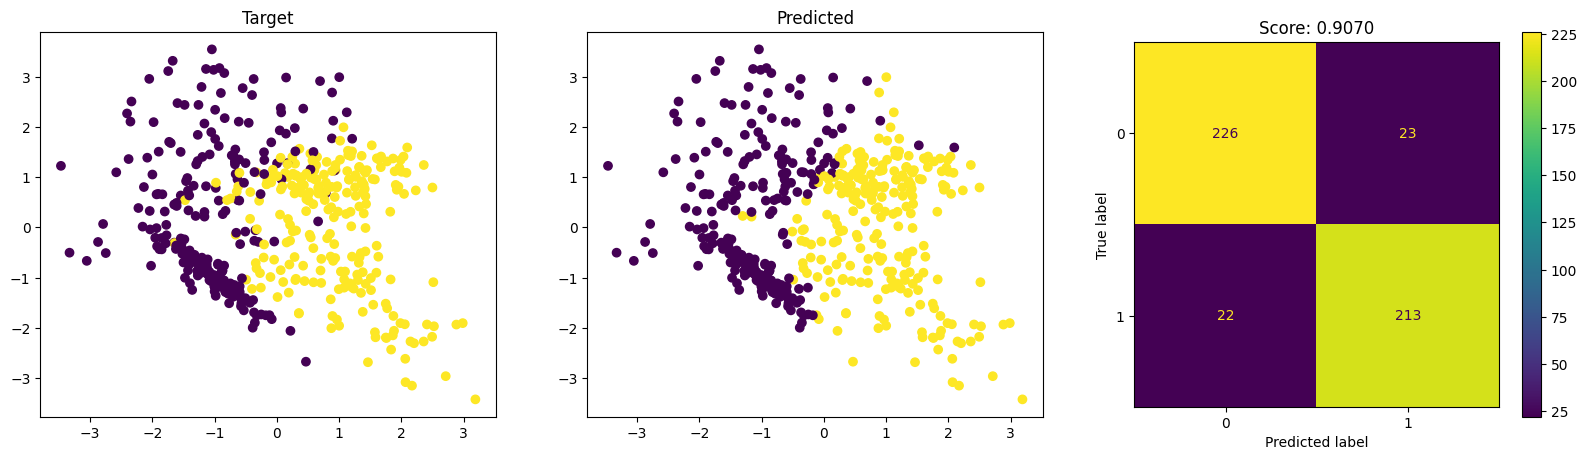

In [76]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(20, 5))

ax1.scatter(X_class_test[:,0], X_class_test[:,1], label = "Data", c = y_class_test)
ax1.set_title('Target')

ax2.scatter(X_class_test[:,0], X_class_test[:,1], label = "Data", c = pred)
ax2.set_title("Predicted")

cm = confusion_matrix(y_class_test, pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(ax = ax3)
disp.ax_.set_title(f"Score: {own_score_classification:.4f}")

In [77]:
print("Porównanie blobs")
print(f"Scikit: {scikit_score_blobs}")
print(f"Własne: {own_score_blobs}")
print("Porównanie classification")
print(f"Scikit: {scikit_score_classification}")
print(f"Własne: {own_score_classification}")

Porównanie blobs
Scikit: 0.9421487603305785
Własne: 0.9173553719008265
Porównanie classification
Scikit: 0.9132231404958677
Własne: 0.9070247933884298


Wpływ wysokości drzewa

In [88]:
clf = DecisionTreeClassifier(criterion = 'entropy', random_state=0, max_depth=99999)
clf.fit(X_train,y_train)
pred = clf.predict(X_test)
score_blobs_inf = clf.score(X_test, y_test)

clf = DecisionTreeClassifier(criterion = 'entropy', random_state=0, max_depth=X.shape[1])
clf.fit(X_train,y_train)
pred = clf.predict(X_test)
score_blobs_feature_count = clf.score(X_test, y_test)

classifier = DecisionTree(max_depth=9999, percentage=1)
classifier.fit(X_class_train, y_class_train)
pred = classifier.predict(X_class_test)
own_score_inf = classifier.score(X_class_test, y_class_test)

classifier = DecisionTree(max_depth=X.shape[1], percentage=1)
classifier.fit(X_class_train, y_class_train)
pred = classifier.predict(X_class_test)
own_score_classification_feature_count = classifier.score(X_class_test, y_class_test)

print(f"[Scikit]Infinity blobs: {score_blobs_inf}")
print(f"[Numeric]Infinity blobs: {own_score_inf}")
print(f"[Scikit]Features count blobs: {score_blobs_feature_count}")
print(f"[Numeric]Features count blobs: {own_score_classification_feature_count}")

[Scikit]Infinity blobs: 0.9659217877094972
[Numeric]Infinity blobs: 0.8574380165289256
[Scikit]Features count blobs: 0.9751396648044692
[Numeric]Features count blobs: 0.8677685950413223


In [78]:
data = np.loadtxt("HTRU_2.csv", delimiter=',', dtype=float)

X, y = data[:,0:8], data[:,-1]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=SEED)
print(X_test.shape)

(3580, 8)


Funkcja do rysowania wykresów

In [79]:
def draw_plots(X_test, y_test, pred, score: float):
    fig, axs = plt.subplots(8, 2, figsize=(20, 40))

    x_values = np.linspace(0.0, 1.0, num=X_test.shape[0])

    for i in range(0,8):
        axs[i, 0].scatter(x_values, X_test[:,i], label = "Data", c = y_test)
        axs[i, 0].set_title('Target')

        axs[i, 1].scatter(x_values, X_test[:,i], label = "Data", c = pred)
        axs[i, 1].set_title("Predicted")

    print(score)
    # cm = confusion_matrix(y_test, pred, normalize='true')
    cm = confusion_matrix(y_test, pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot()
    disp.ax_.set_title(f"Score: {score}")

Poszukiwanie parametrów

In [80]:
from sklearn.model_selection import GridSearchCV

parameters = {
    		'criterion' : ['gini', 'entropy'],
			'max_depth' : [2,4,6,8,10,12],
			'min_samples_split' : [2,3,4,5],
			'min_samples_leaf' : [1,2,3,4]
            }

grid_search = GridSearchCV(DecisionTreeClassifier(), parameters, n_jobs=-1)

grid_search.fit(X_train, y_train)
best = grid_search.best_params_

In [81]:
print('Best Criterion:', best['criterion'])
print('Best max_depth:', best['max_depth'])
print('Best min_samples_split:', best['min_samples_split'])
print('Best min_samples_leaf:', best['min_samples_leaf'])

Best Criterion: gini
Best max_depth: 4
Best min_samples_split: 3
Best min_samples_leaf: 4


0.975977653631285


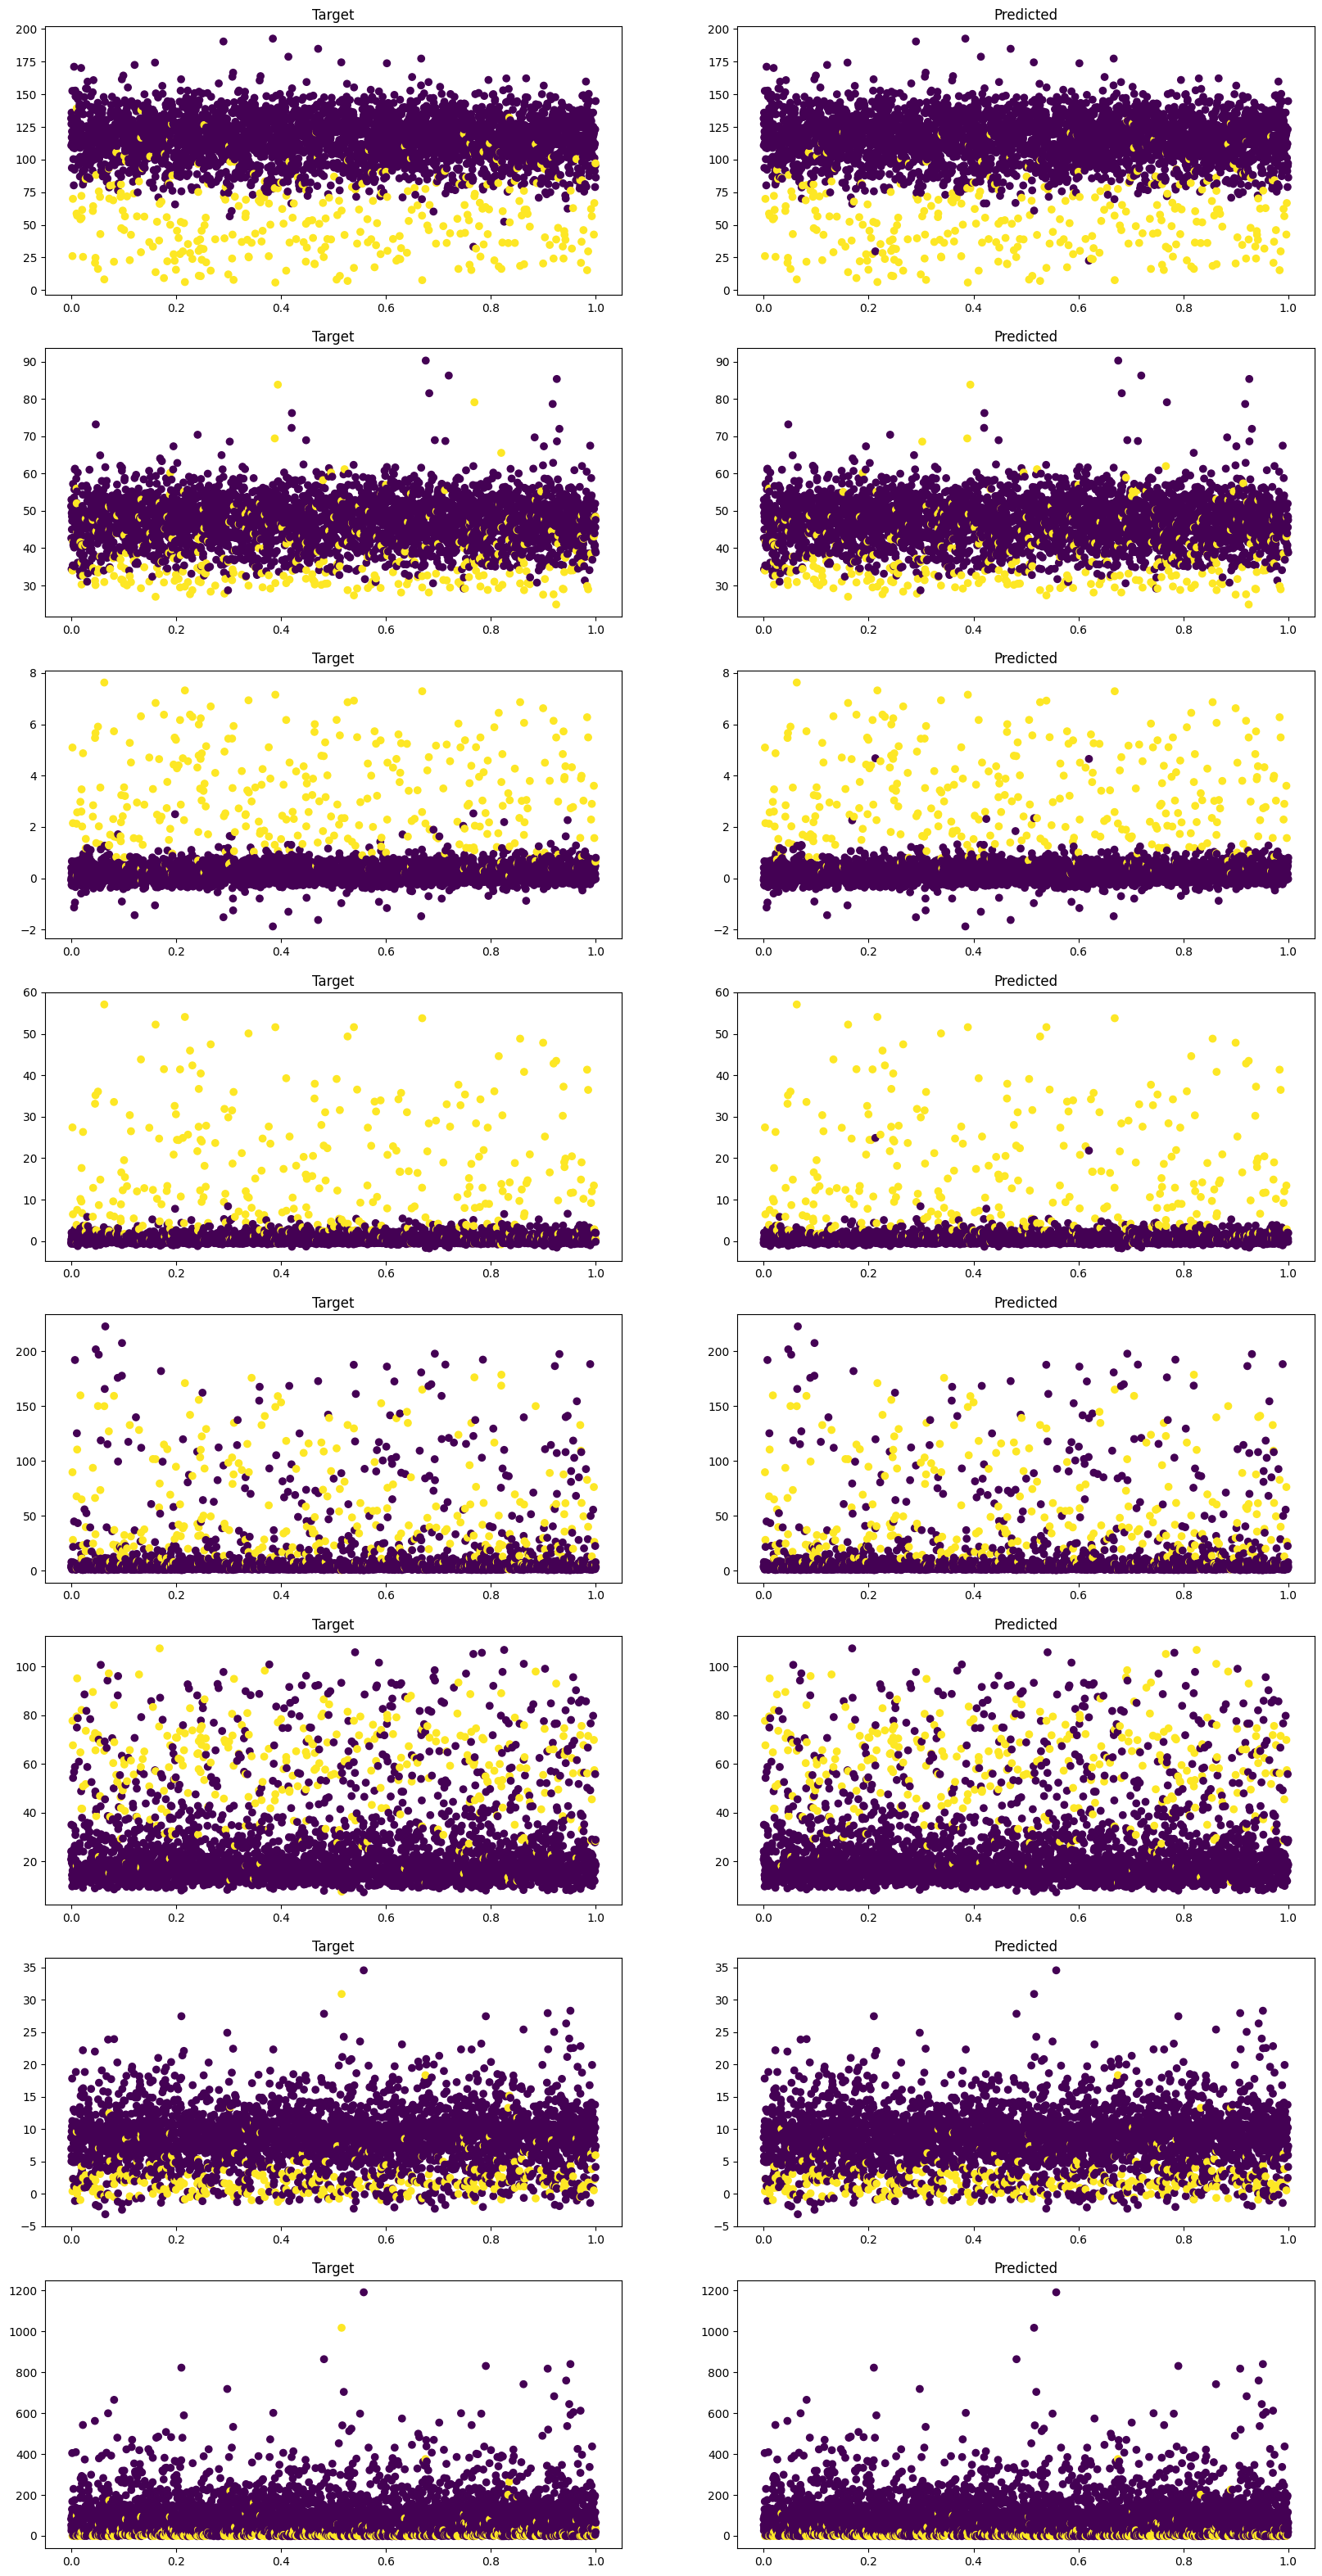

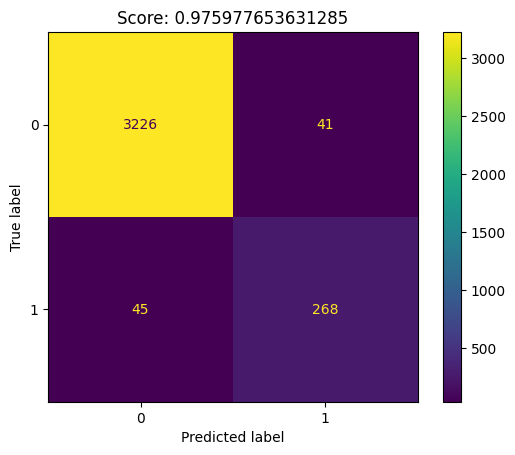

In [82]:
from sklearn.tree import DecisionTreeClassifier
clf = DecisionTreeClassifier(criterion = 'entropy', random_state=0, max_depth=10, min_samples_split=2, min_samples_leaf=2)
clf.fit(X_train,y_train)
pred = clf.predict(X_test)
clf.score(X_test, y_test)

draw_plots(X_test, y_test, pred, clf.score(X_test, y_test))

0.9810055865921787


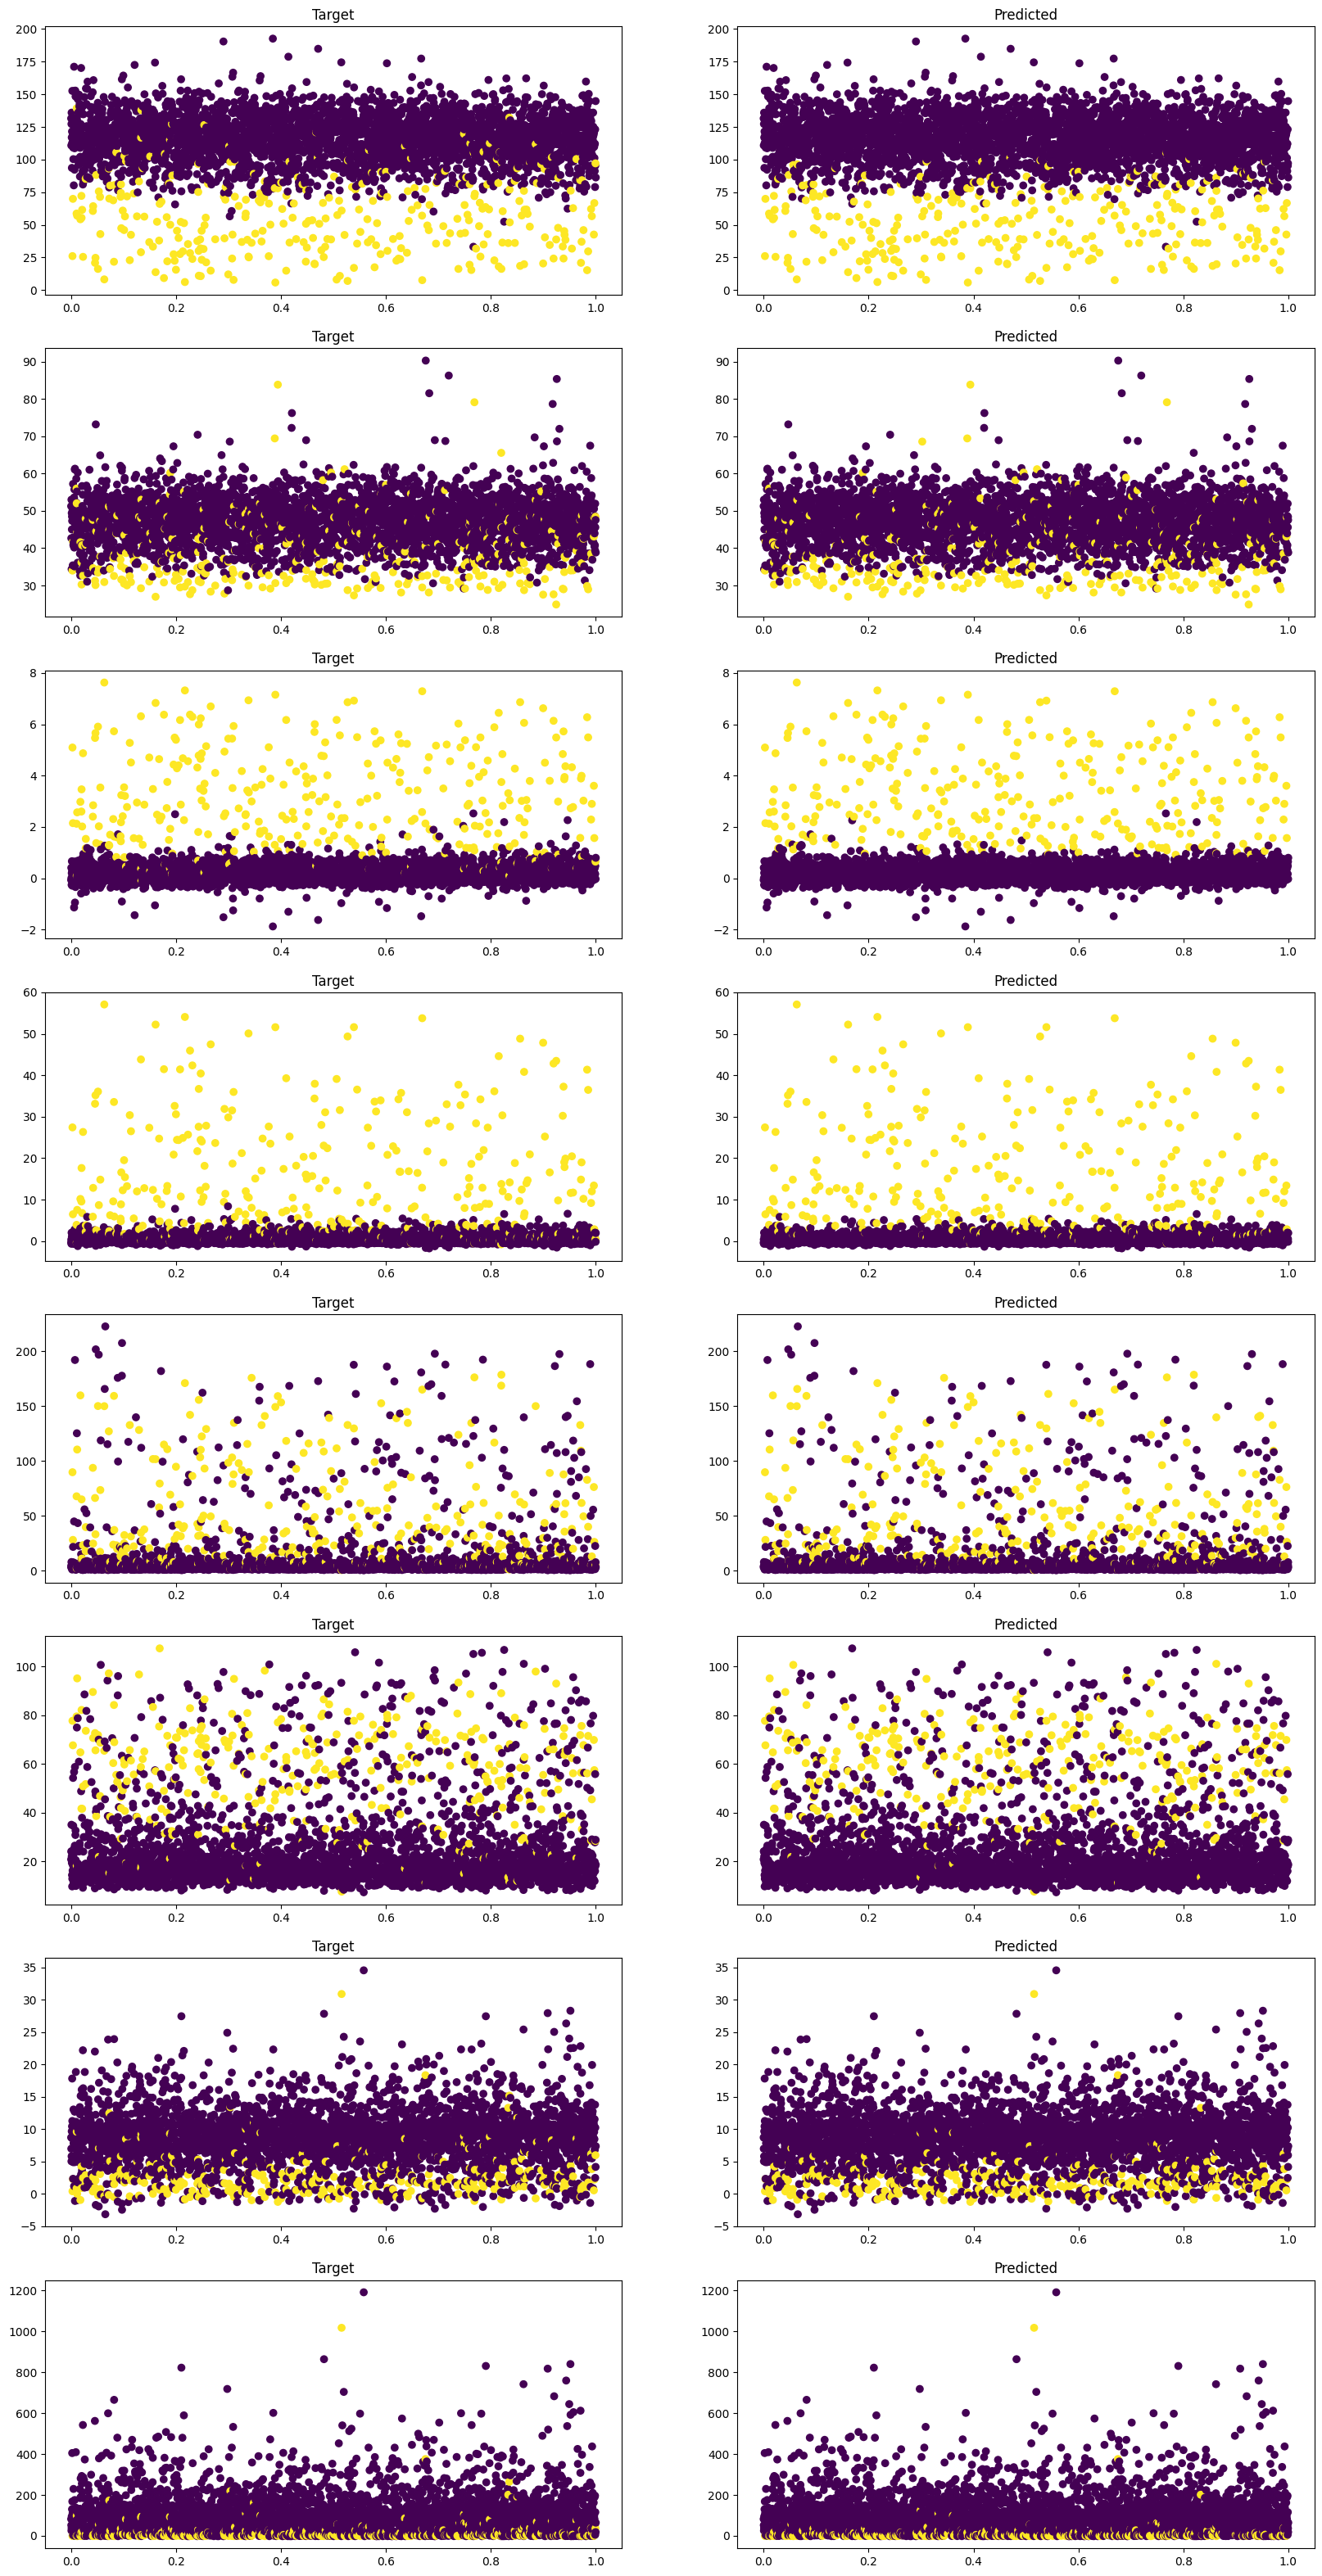

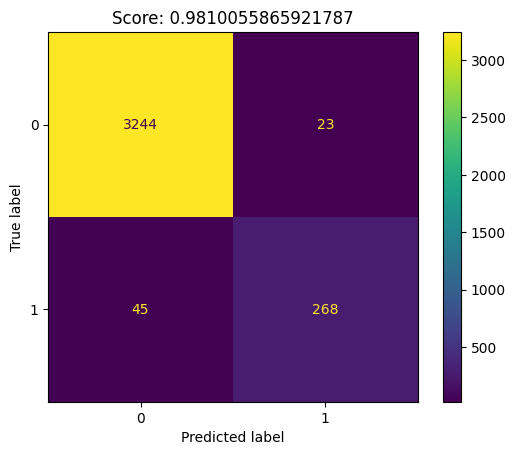

In [83]:
clf = DecisionTreeClassifier(criterion = best['criterion'], random_state=0, max_depth= best['max_depth'], min_samples_split=best['min_samples_split'], min_samples_leaf=best['min_samples_leaf'])
clf.fit(X_train,y_train)
pred = clf.predict(X_test)

draw_plots(X_test, y_test, pred, clf.score(X_test, y_test))